# Imports and initialisation

In [257]:
import sqlite3
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import pymongo
conn = sqlite3.connect('./database.sqlite')
cur = conn.cursor()

# Goal scored

In [204]:
def goal_scored(division,season):
    if division not in ['E0','D1','D2']:
        print('The division argument is invalid. It must either be: \n D1 for Bundesliga, \n D2 for Bundesliga 2 \n E0 for Premier League')
    elif season < 1993 or season > 2016:
        print('Sorry, we only have data for seasons between 1993 and 2016!')
    else:
        conn = sqlite3.connect('./database.sqlite')
        cur = conn.cursor()
        query = """
                SELECT Div,HomeTeam, SUM(FTHG)+SUM(FTAG) as Goal_scored 
                FROM Matches 
                WHERE Season = {} 
                GROUP BY HomeTeam 
                ORDER BY Div, Goal_scored desc, HomeTeam""".format(season)
        df = pd.DataFrame(cur.execute(query).fetchall())
        df.columns = [x[0] for x in cur.description]
        g_s = sum(df[df['Div']==division]['Goal_scored'])
        return '{} goals were scored in {} during the {} season!'.format(g_s, division, season)
    
# Add a default counting for all the division and all the season at once

In [254]:
goal_scored('D1',2011)

The division argument is invalid. It must either be: 
 D1 for Bundesliga, 
 D2 for Bundesliga 2 
 E0 for Premier League


# DarkSky API

## Generate the dataset

In [248]:
conn = sqlite3.connect('./database.sqlite')
cur = conn.cursor()
query = """
        SELECT *,
            CASE FTR 
                WHEN 'A' THEN AwayTeam
                WHEN 'H' THEN HomeTeam
                ELSE Null
            END as 'Winner',
            CASE FTR 
                WHEN 'A' THEN HomeTeam
                WHEN 'H' THEN AwayTeam
                ELSE Null
            END as 'Loser'
        FROM Matches
        WHERE Season = 2011
        """
df = pd.DataFrame(cur.execute(query).fetchall())
df.columns = [x[0] for x in cur.description]
df = df.dropna()
df = df.reset_index()
df['Weather'] = pd.Series(0, index=df.index)
df

,index,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Winner,Loser,Weather
0,0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,Nurnberg,0
1,1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,Bayern Munich,Stuttgart,0
2,2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,Bayern Munich,Wolfsburg,0
3,3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,Mainz,Bayern Munich,0
4,5,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H,M'gladbach,Bayern Munich,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,987,44870,E0,2011,2012-05-13,Sunderland,Man United,0,1,A,Man United,Sunderland,0
725,988,44871,E0,2011,2012-05-13,Swansea,Liverpool,1,0,H,Swansea,Liverpool,0
726,989,44872,E0,2011,2012-05-13,Tottenham,Fulham,2,0,H,Tottenham,Fulham,0
727,990,44873,E0,2011,2012-05-13,West Brom,Arsenal,2,3,A,Arsenal,West Brom,0


### Use the API to populate the weather column

In [251]:
# Function to get the weather
apikey = dict(json.load(open('/home/antoine/.apikeys')))['Darksky']
def dkSky(division, date):
    lat = None
    long = None
    if division == 'E0':
        lat = 51.528308
        lon = -0.3817815
    else:
        lat = 52.5065133
        lon = 13.1445703
    response = requests.get('https://api.darksky.net/forecast/{}/{},{},{}T16:00:00'.
    format(apikey,lat,lon,date))
    return(response.json()['daily']['data'][0].get('icon', 'Clear'))

In [252]:
for i in range(0,len(df['Weather'])):
    df['Weather'][i] = dkSky(df['Div'][i],df['Date'][i])
df

<ipython-input-252-e71dd94dd522>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weather'][i] = dkSky(df['Div'][i],df['Date'][i])


,index,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Winner,Loser,Weather
0,0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,Nurnberg,rain
1,1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,Bayern Munich,Stuttgart,partly-cloudy-day
2,2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,Bayern Munich,Wolfsburg,partly-cloudy-day
3,3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,Mainz,Bayern Munich,wind
4,5,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H,M'gladbach,Bayern Munich,rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,987,44870,E0,2011,2012-05-13,Sunderland,Man United,0,1,A,Man United,Sunderland,clear-day
725,988,44871,E0,2011,2012-05-13,Swansea,Liverpool,1,0,H,Swansea,Liverpool,clear-day
726,989,44872,E0,2011,2012-05-13,Tottenham,Fulham,2,0,H,Tottenham,Fulham,clear-day
727,990,44873,E0,2011,2012-05-13,West Brom,Arsenal,2,3,A,Arsenal,West Brom,clear-day


In [253]:
df.to_csv('df.csv', sep=',', encoding='utf-8')

# Wins vs Losses in 2011 season

In [192]:
# Create the pair Team:Division
conn = sqlite3.connect('./database.sqlite')
cur = conn.cursor()
query = """
        SELECT Unique_Teams.TeamName as Teams, Matches.Div as Division
        FROM Unique_Teams
        JOIN Teams_in_Matches ON Unique_Teams.Unique_Team_ID = Teams_in_Matches.Unique_Team_ID
        JOIN Matches ON Teams_in_Matches.Match_ID = Matches.Match_ID
        WHERE Matches.Season = 2011
        GROUP BY Unique_Teams.TeamName
        """
divs = pd.DataFrame(cur.execute(query).fetchall())
divs.columns = [x[0] for x in cur.description]

In [198]:
# Create the dataframe used to generate the graph
teams = df['Winner'].append(df['Loser'])
uniqueTeams = set(teams)
teamsperf = pd.DataFrame(uniqueTeams)
teamsperf.columns = ['Teams']
teamsperf['Victory'] = [len(df[df['Winner']==team]) for team in uniqueTeams]
teamsperf['Defeat'] = [len(df[df['Loser']==team]) for team in uniqueTeams]
teamsperf = teamsperf.merge(divs, on='Teams')
teamsperf = teamsperf.sort_values(by=['Division', 'Teams'])

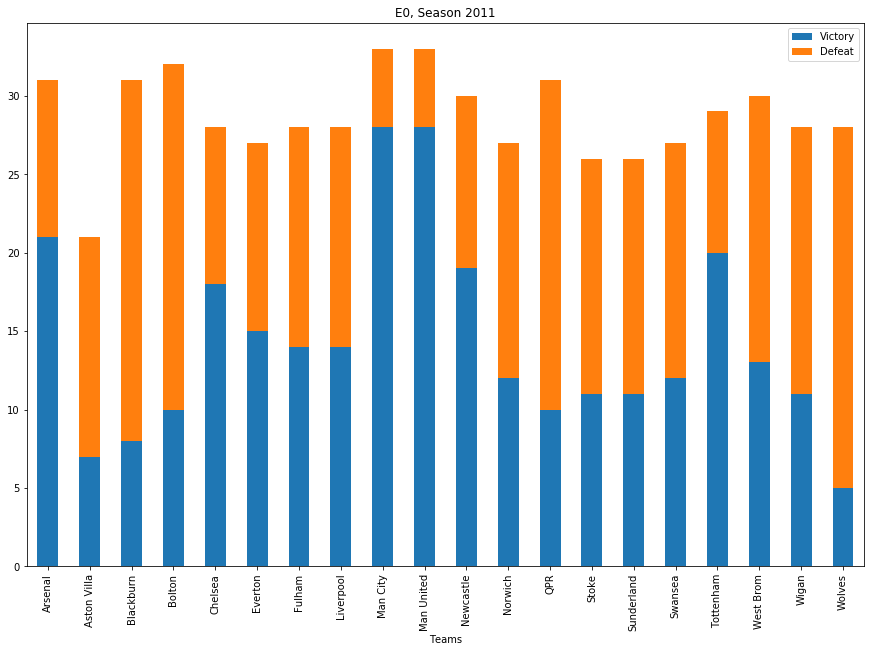

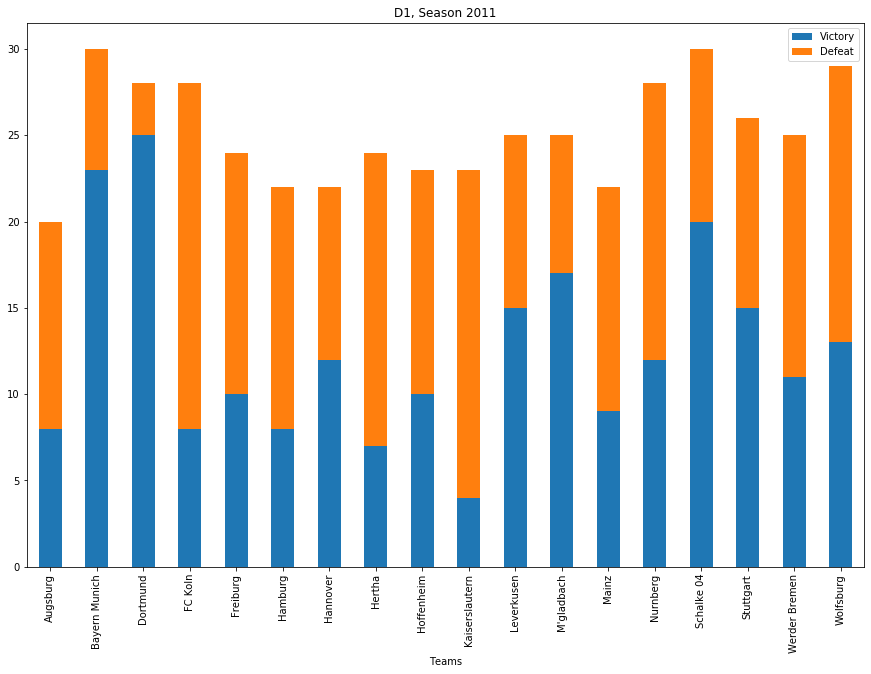

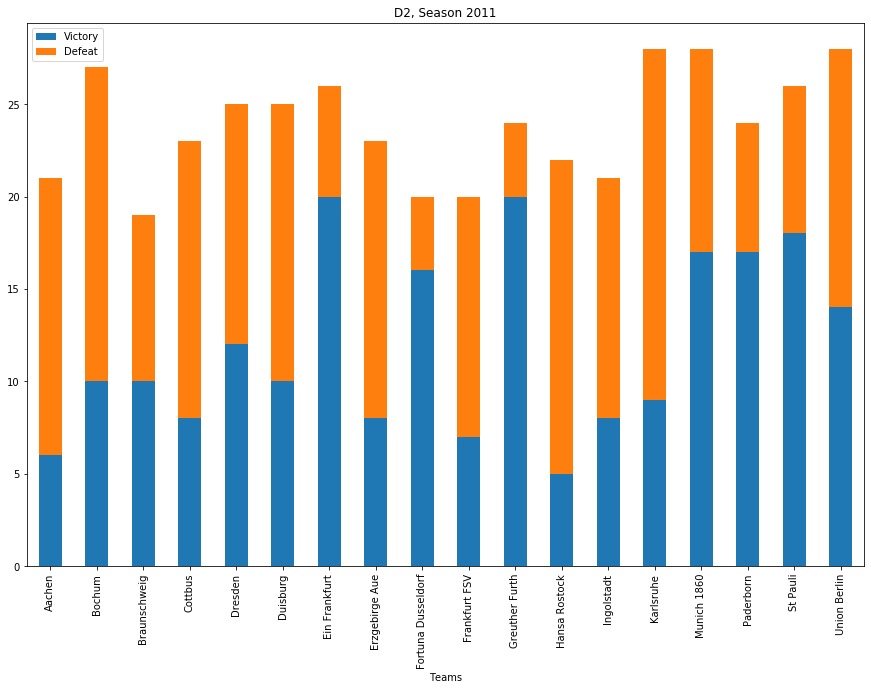

In [199]:
# Create the graphs, per Division
for i in ['E0','D1','D2']:
    plotdf = teamsperf[teamsperf['Division']==i]
    plotdf.plot(x='Teams', y=['Victory','Defeat'],kind='bar',figsize=(15,10), stacked=True, sort_columns=True,
                title='{}, Season 2011'.format(i))

# It's rainy day

In [286]:
df

,index,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Winner,Loser,Weather
0,0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,Bayern Munich,Nurnberg,rain
1,1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,Bayern Munich,Stuttgart,partly-cloudy-day
2,2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,Bayern Munich,Wolfsburg,partly-cloudy-day
3,3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,Mainz,Bayern Munich,wind
4,5,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H,M'gladbach,Bayern Munich,rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,987,44870,E0,2011,2012-05-13,Sunderland,Man United,0,1,A,Man United,Sunderland,clear-day
725,988,44871,E0,2011,2012-05-13,Swansea,Liverpool,1,0,H,Swansea,Liverpool,clear-day
726,989,44872,E0,2011,2012-05-13,Tottenham,Fulham,2,0,H,Tottenham,Fulham,clear-day
727,990,44873,E0,2011,2012-05-13,West Brom,Arsenal,2,3,A,Arsenal,West Brom,clear-day


# MongoDB

In [265]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['FootyStats']
mycollection = mydb['TeamNames']

In [280]:
# goals = {'goalScored2011D1' : goal_scored('D1',2011),
#             'goalScored2011D2' : goal_scored('D2',2011),
#             'goalScored2011E0' : goal_scored('E0',2011)}
# mycollection.insert_one(goals)

In [281]:
query = mycollection.find({})
for document in query:
    print(document)

{'_id': ObjectId('5e34267c5afaf4eddae57112'), 'goalScored2011D1': '875 goals were scored in D1 during the 2011 season!', 'goalScored2011D2': '855 goals were scored in D2 during the 2011 season!', 'goalScored2011E0': '1066 goals were scored in E0 during the 2011 season!'}
